# RESUME OPTIMIZATION - A data-driven & programmatic attempt

## Problem Statement:
- Job application can be a difficult task in current economy
- Calls for tailoring resume to job description
- Doing so manually can be a tedious process

## Potential approach:
- Can use a data driven approach
- Use of programming language, available APIs and NLP

In [1]:
# import dependencies
import requests
import json
import pandas as pd
from collections import Counter

from wordcloud import WordCloud # Word cloud visualization of the text
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize  # For tokenization
from nltk.corpus import stopwords  # For stopword removal
from nltk.stem import PorterStemmer, WordNetLemmatizer  # For stemming and lemmatization
from nltk import pos_tag, ne_chunk  # For POS tagging and Named Entity Recognition (NER)
import string  # For text normalization

# Download necessary datasets (only needed once)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('maxent_ne_chunker')
nltk.download('words')

# Scikitlearn for cosine similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# import env variables from colab and store in a variable
from google.colab import userdata
EMSI_CLIENT_ID = userdata.get('EMSI_CLIENT_ID')
EMSI_CLIENT_SECRET = userdata.get('EMSI_CLIENT_SECRET')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [2]:
job_description = """
Are you a technologist who has a hunger to dig deep and get involved in providing first-class solutions to real-world problems?

We have opportunities for Mid-Senior Software Engineers .

What will you do?

You will be responsible for the ownership of key projects, working across all phases of the SDLC, including analysis, design, development, testing and deployment. As a Senior Developer, you will be accountable for issuing technical guidance to Junior Developers, including overseeing their deliverables and providing architectural guidance.

What experience will you need?

    Proficient in Python development, Experience in web frameworks preferably Fast API (In use) or with Django/Flask and able to pick up Fast API, API development, exposure to UI
    Using Amazon ECS (Elastic container services)
    Mango DB in scope now and another RDBMS in future
    End to end Python based streaming and batch jobs
    Experience in microservices
    Understanding of both relational and non-relational databases
    Experience with MongoDB and/or Oracle preferred
    Able to write shell & batch programs
    Ability to work independently with end users to gather requirements and design solutions
    Demonstrated Subject Matter Expert (SME) in area(s) of Applications Development
    Experience in version control tools like GIT, SVN and Bitbucket
"""


resume = """
 # JOHN SMITH
  **Email**: john.smith@gmail.com | **Phone**: 123-456-7890 | **Address**: 1234 Fake St, Canada

  ## PROFESSIONAL SUMMARY

  Dedicated Python developer with extensive experience in web development, database management, and data analysis. Proficient in Django and Flask, with proven success in optimizing business processes.

  ## SKILLS

  - **Programming & Web**: Python (Django, Flask) , HTML/CSS, JavaScript/NodeJS
  - **Data & Databases**: SQL, PostgreSQL, MongoDB, Pandas, NumPy, Matplotlib, Seaborn
  - **Tools & Technologies**: Git/ Github, Docker, Linux, AI tools (Copilot, ChatGPT etc)
  - **Cloud Computing**: AWS, Google Cloud, Oracle Cloud

  ## EXPERIENCE

  **Data Analyst** *Company 1 | May 2022 – Present*

  - **Data Analysis**: Conducted analysis using SQL/ Pandas; created visualizations to track spend.
  - **Database Management**: Managed PostgreSQL for database administration and query optimization.

  ** Analyst** *Company 2 | June 2020 - May 2022*

  - **Web App Development**: Developed contract KPI evaluation CRUD app with Python Flask and Bootstrap.
  - **Automated Reporting**: Implemented Python-based reports and scheduled status email/text with Twilio/Sendgrid API, enhancing decision-making with actionable insights.
  - **Data-Driven Decisions**: Utilized analytics tools to track KPIs, providing actionable operational insights.

  **Business Analyst** *Company 3 | May 2019 - April 2020*

  - **Cloud Deployment**: Deployed code to Oracle Cloud and researched cloud providers such as AWS, Azure and GCP for deployment using IaaS vs PaaS strategy.

  ## EDUCATION

  - **B.Sc. in Engineering** | University of Toronto | 2020
"""

### Natural Language Processing - Cosine Similarity

In [3]:
# Preprocessing function
def preprocess(text):
    text = text.lower()  # Lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return " ".join(tokens)

In [4]:
def wordcloud_generator(text):
  # Create a WordCloud object
  wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

  # Display the word cloud
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")  # Hide axes
  plt.show()

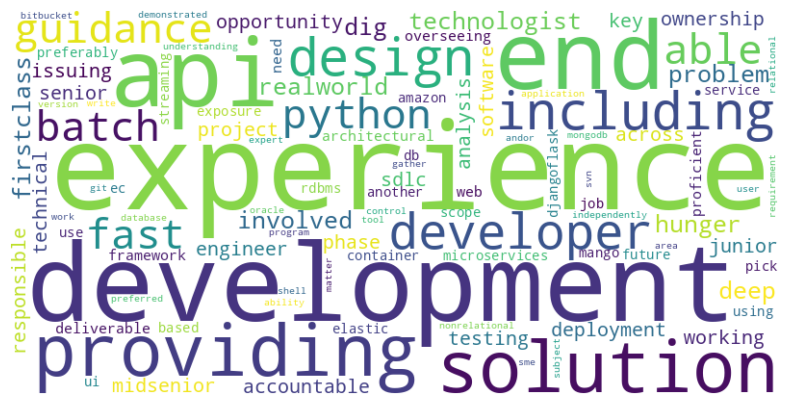

In [5]:
# Word cloud of jobs
wordcloud_generator(preprocess(job_description))

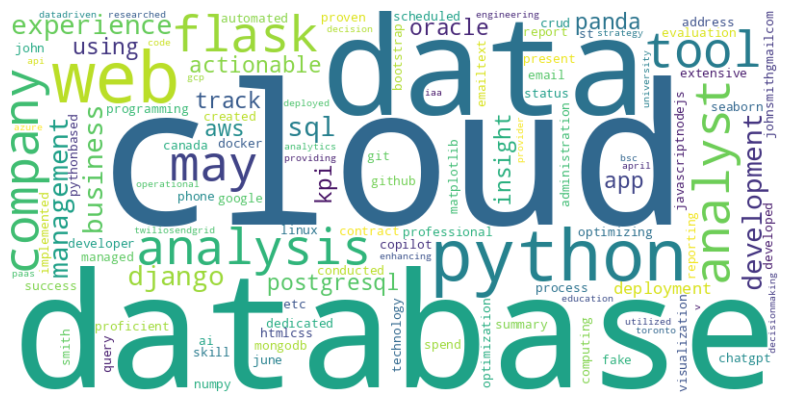

In [6]:
# Word cloud of resume
wordcloud_generator(preprocess(resume))

In [7]:
# Convert texts into TF-IDF vectors
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform([preprocess(job_description), preprocess(resume)])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])

print(f"Cosine Similarity: {cosine_sim[0][0]:.4f}")

Cosine Similarity: 0.1324


### Lightcast skills extraction API

In [8]:
# Function to obtain access token for Lightcast API and get skills

def get_access_token(EMSI_CLIENT_ID, EMSI_CLIENT_SECRET):
    """Retrieves an access token."""
    url = "https://auth.emsicloud.com/connect/token"
    payload = f"client_id={EMSI_CLIENT_ID}&client_secret={EMSI_CLIENT_SECRET}&grant_type=client_credentials&scope=emsi_open"
    headers = {"Content-Type": "application/x-www-form-urlencoded"}

    response = requests.request("POST", url, data=payload, headers=headers)
    return response.json()

def get_skills(text, access_token, confidence_threshold=0.6):
    """Retrieves the latest skills data."""
    url = "https://emsiservices.com/skills/versions/latest/extract"

    payload = {
    "text": text,
    "confidenceThreshold": confidence_threshold
    }
    headers = {
        "Authorization": f"Bearer {access_token}",
        "Content-Type": "application/json"
    }

    try:
        response = requests.request("POST", url, json=payload, headers=headers)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error getting skills: {e}")
        return None

In [9]:
# Obtain Access Token
access_token = get_access_token(EMSI_CLIENT_ID, EMSI_CLIENT_SECRET)["access_token"]

In [10]:
job_skills = get_skills(text= job_description, access_token = access_token, confidence_threshold=0.4)
current_skills = get_skills(text= resume, access_token = access_token, confidence_threshold=0.4)

In [11]:
print(job_skills)
print(current_skills)

{'attributions': [{'name': 'Wikipedia', 'text': 'Wikipedia extracts are distributed under the CC BY-SA license (https://creativecommons.org/licenses/by-sa/3.0/)'}], 'data': [{'confidence': 1.0, 'skill': {'description': 'A relational database is a digital database based on the relational model of data, as proposed by E. F. Codd in 1970.\nA software system used to maintain relational databases is a relational database management system (RDBMS). Many relational database systems have an option of using the SQL for querying and maintaining the database.', 'descriptionSource': 'https://en.wikipedia.org/wiki/Relational_database', 'id': 'KS122QK6TH01FWQ9X8CH', 'infoUrl': 'https://lightcast.io/open-skills/skills/KS122QK6TH01FWQ9X8CH', 'name': 'Relational Databases', 'tags': [{'key': 'wikipediaExtract', 'value': 'A relational database is a digital database based on the relational model of data, as proposed by E. F. Codd in 1970.\nA software system used to maintain relational databases is a relat

In [12]:
# Convert skills to DataFrame
def skill_to_df(skills):
  df = pd.DataFrame({
    'Skill Name': [item['skill']['name'] for item in skills['data']],
    'Confidence Level': [item['confidence'] for item in skills['data']]})
  return df

In [20]:
job_skills_df = skill_to_df(job_skills)
current_skills_df = skill_to_df(current_skills)

print(job_skills_df.head(10))
print("\n")
print(current_skills_df.head(10))

                                Skill Name  Confidence Level
0                     Relational Databases               1.0
1                            Microservices               1.0
2                     Software Engineering               1.0
3             Git (Version Control System)               1.0
4         Amazon Elastic Container Service               1.0
5                      Development Testing               1.0
6                           Web Frameworks               1.0
7            Python (Programming Language)               1.0
8                   Django (Web Framework)               1.0
9  Application Programming Interface (API)               1.0


                           Skill Name  Confidence Level
0  Infrastructure As A Service (IaaS)               1.0
1                     Cloud Computing               1.0
2                            Sendgrid               1.0
3     Bootstrap (Front-End Framework)               1.0
4                        Oracle Cloud          

In [21]:
import pandas as pd

# Convert DataFrames to sets
job_skills = set(job_skills_df['Skill Name'])
resume_skills = set(current_skills_df['Skill Name'])

# Identify skill categories
common_skills = job_skills & resume_skills
missing_skills = job_skills - resume_skills
extra_skills = resume_skills - job_skills

# Print results in a structured format
print("✅ Matched Skills:")
print("\n".join(common_skills) if common_skills else "None")

print("\n❌ Missing from Resume:")
print("\n".join(missing_skills) if missing_skills else "None")

print("\n➕ Extra in Resume:")
print("\n".join(extra_skills) if extra_skills else "None")


✅ Matched Skills:
Python (Programming Language)
MongoDB
Flask (Web Framework)
Django (Web Framework)
Git (Version Control System)

❌ Missing from Resume:
User Interface (UI)
Web Frameworks
Relational Database Management Systems
Microservices
Relational Databases
Systems Development Life Cycle
Application Programming Interface (API)
Version Control
Amazon Elastic Container Service
Development Testing
Software Engineering
Bitbucket
Apache Subversion

➕ Extra in Resume:
Google Cloud Platform (GCP)
Infrastructure As A Service (IaaS)
PostgreSQL
SQL (Programming Language)
Bootstrap (Front-End Framework)
Node.js (Javascript Library)
Cloud Computing
Linux
JavaScript (Programming Language)
Generative Artificial Intelligence
Sendgrid
Microsoft Azure
Github
Seaborn
Web Development
Query Optimization
NumPy (Python Package)
HyperText Markup Language (HTML)
Business Process
Key Performance Indicators (KPIs)
Docker (Software)
Data Analysis
Data-Driven Decision Making
ChatGPT
Create Read Update and De

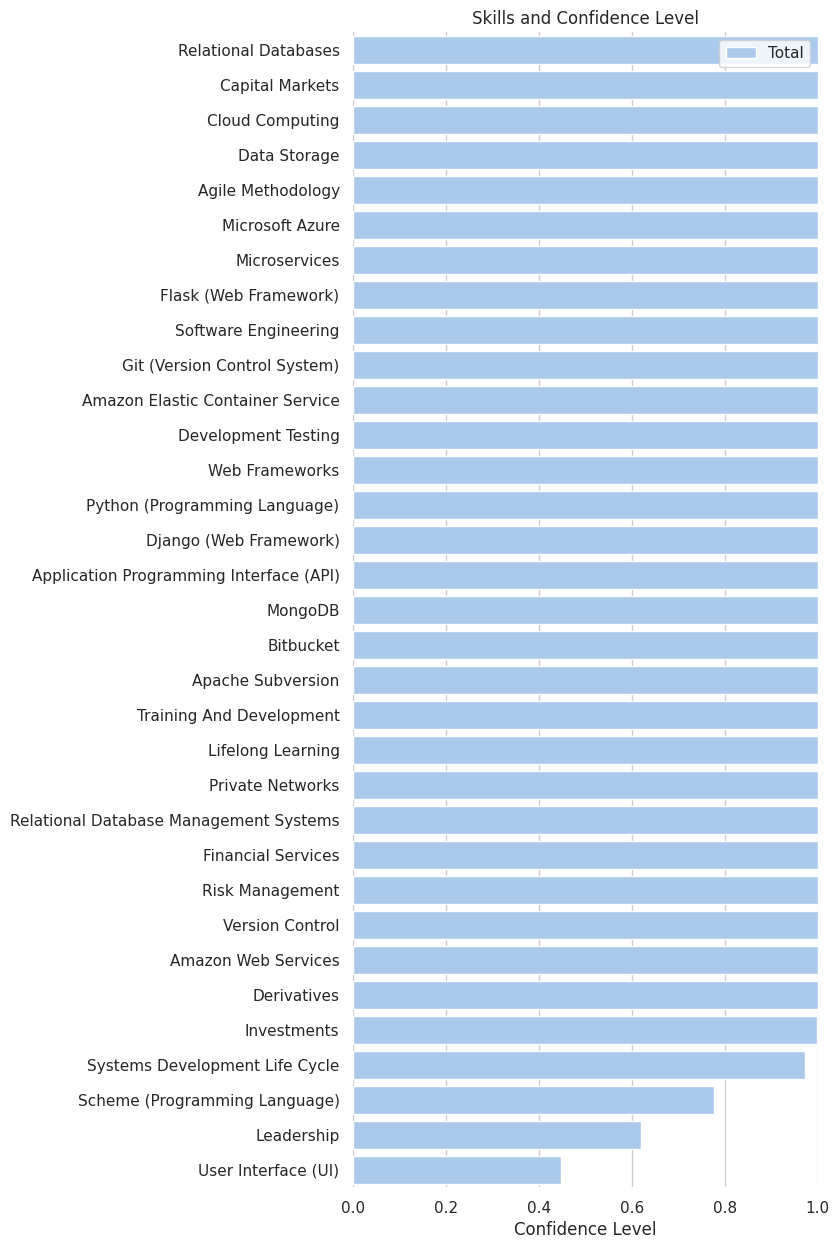

In [ ]:
# Bar plot the skills and confidence level
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="Confidence Level", y="Skill Name", data=df,
            label="Total", color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(xlim=(0, 1), ylabel="",
       xlabel="Confidence Level")
ax.set_title("Skills and Confidence Level")
sns.despine(left=True, bottom=True)

### Gemini LLM API - Resume Creation

### A/B Testing

## Future Works